# Projet IPEO

### Data loading

In [11]:
import os
import random
from collections import defaultdict

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
import matplotlib.pyplot as plt
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Device utilisé : cpu
Classes : ['damage', 'no_damage']
Nombre d'images (train) : 19000
Nombre d'images (val) : 2000
Nombre d'images (test) : 2000


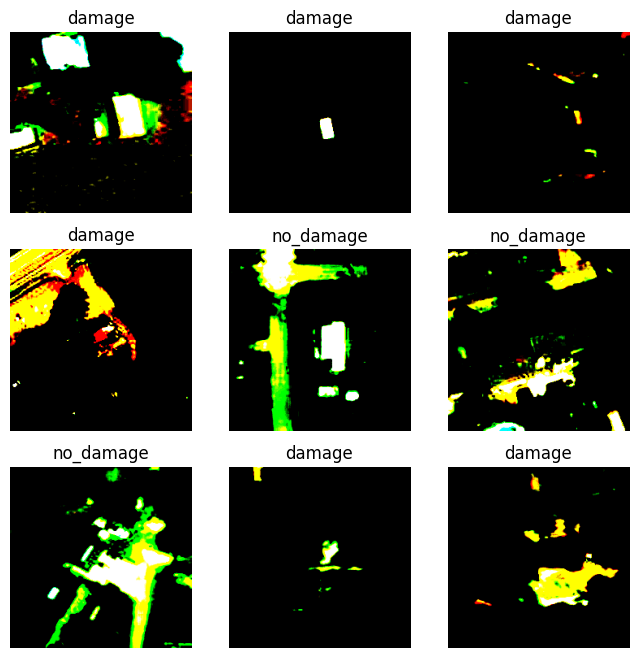

In [6]:
base_dir = "ipeo_hurricane_for_students"

from UCMerced_module import default_transform, unnormalize # J'utilise default_transform qui vient de la fonction du prof, mais peut-être à modifier

train_ds = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=default_transform)
val_ds   = datasets.ImageFolder(os.path.join(base_dir, "validation"), transform=default_transform)
test_ds  = datasets.ImageFolder(os.path.join(base_dir, "test"), transform=default_transform)

# Détection du device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)


# Ajustements DataLoader pour CPU (si pas de GPU) : réduire batch_size si besoin, num_workers=0 sur macOS (2 dans le cours)
# à voir si on garde ça comme ça
batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds, batch_size=batch_size, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, num_workers=0, pin_memory=False)

print("Classes :", train_ds.classes)
print("Nombre d'images (train) :", len(train_ds))
print("Nombre d'images (val) :", len(val_ds))
print("Nombre d'images (test) :", len(test_ds))

def show_batch(loader):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for img, label, ax in zip(images[:9], labels[:9], axes.flat):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(train_ds.classes[label])
        ax.axis("off")
    plt.show()

show_batch(train_loader)

### Model loading

In [ ]:
from torchvision.models import resnet18, resnet34, mobilenet_v3_small

# load a resnet18 with 21 classes and move to device
#model = resnet18(num_classes=21).to(device)
#model

# load a resnet34 with 21 classes and move to device
#model = resnet34(num_classes=21).to(device)
#model

# load a mobilnet_v3_small with 21 classes and move to device
model = mobilenet_v3_small(num_classes=21).to(device)
model

# Load the model :
#model = AlexNet(num_classes=21).to(device)
#model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Loss function

In [ ]:
# Define the loss function
criterion = CrossEntropyLoss()

### Optimizer

In [ ]:
learning_rate = 0.01

optimizer = SGD(model.parameters(),lr=learning_rate)

### Training step

In [10]:
import torch.nn.functional as F

def training_step(batch, model, optimizer, device):
    model.train()
    optimizer.zero_grad()

    x, y = batch
    x = x.to(device)
    y = y.to(device)

    y_hat = model(x)
    loss = criterion(y_hat, y)

    loss.backward()
    optimizer.step()

    preds = y_hat.argmax(1).cpu().detach().numpy()
    gt = y.cpu().detach().numpy()
    accuracy = (preds == gt).mean()

    return loss.item(), float(accuracy)


### Training and validating over the full batch

In [ ]:
def train_epoch(train_dl, model, optimizer, device):

    # collect some statistics
    losses, accuracies = [], []

    for batch in train_dl:
        loss, accuracy = training_step(batch, model, optimizer, device)

        losses.append(loss)
        accuracies.append(accuracy)

    if len(losses) == 0:
        return 0.0, 0.0

    # return averaged losses and accuracies
    return float(np.mean(losses)), float(np.mean(accuracies))


def validate_epoch(val_dl, model, device):
    """Évalue le modèle sur l'ensemble de validation (sans backprop)."""
    model.eval()
    losses, accuracies = [], []

    with torch.no_grad():  # pas de gradient pour la validation
        for batch in val_dl:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)

            preds = y_hat.argmax(1).cpu().detach().numpy()
            gt = y.cpu().detach().numpy()
            accuracy = (preds == gt).mean()

            losses.append(loss.item())
            accuracies.append(accuracy)

    if len(losses) == 0:
        return 0.0, 0.0

    return float(np.mean(losses)), float(np.mean(accuracies))
